#  Aprendizaje a Máquina I

## Manel Soler Sanz y Manuel Jiménez Haro

 


## Introducción
En este trabajo vamos a trabajar con una base de datos que contiene diferentes tipos de sonidos y sus etiquetas correspondientes. En particular, nuestros sonidos corresponden a  : **'Rain', 'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops'.**

El objetivo de este trabajo será conseguir construir un modelo supervisado que consiga clasificar estos sonidos según su procedencia. Para ello, primeramente vamos a utilizar algoritmos de clustering NO supervisado, para encontrar posibles patrones en los datos y ver de una forma superficial la representación en el espacio de características que tienen cada uno de los diferentes sonidos. Después, utilizaremos algoritmos de clustering supervisados para conseguir un modelo con capacidad de predecir resultados con una precisión notable. Utilizaremos técnicas no supervisadas para elegir nuestro dataset más representativo y también utilizareremos métodos de extracción de características para mejorar y/o depurar nuestro modelo. 



Importamos las librerias que vamos a utilizar a lo largo del trabajo

In [34]:
import skfuzzy as fuzz

import numpy as np
import sklearn
import matplotlib.pyplot as plt
import librosa, librosa.display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier


Importamos los datos

In [35]:

task_names = [
 ['Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat'],
 ['Rain', 'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops'],
 ['Hen', 'Insects (flying)', 'Sheep', 'Crow', 
  'Wind', 'Pouring water', 'Toilet flush',  'Thunderstorm', 
  'Laughing', 'Brushing teeth'],
 ['Crying baby', 'Sneezing', 'Clapping', 'Breathing', 'Coughing', 'Footsteps'],
 ['Door knock', 'Mouse click', 'Keyboard typing', 'Door, wood creaks', 'Can opening',
  'Washing machine'],
 ['Snoring',  'Drinking, sipping',
  'Vacuum cleaner', 'Clock alarm', 'Clock tick', 'Glass breaking',
  'Church bells', 'Airplane', 'Fireworks', 'Hand saw'],
 ['Helicopter', 'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train']]


print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

task=2
class_names = task_names[task-1]
srate = 22050        # sampling rate
c = len(class_names) # no. of classes

# load data
data = np.load('adata%d.npy'%task)  # sonidos tarea 2 , tenemos etiquetas
#data = np.load('udata.npy')  # todos los sonidos, sin etiquetas

n,d = data.shape  # size and (raw) dimension
nc = n//c         # samples per class

print('%d samples from %d classes'%(n,c))
print('Raw dimension is %d corresponding to %.1f seconds of audio'%(d,d/srate))


# set up labs
labs = np.int16(np.kron(np.arange(c),np.ones(nc)))



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
720 samples from 6 classes
Raw dimension is 66150 corresponding to 3.0 seconds of audio


## Generamos nuestro Data Set

Para poder trabajar con nuestros datos vamos a transformalos al espacio definido por los Mel Frequency Cepstral Coeﬃcients (MFFC). Estos coeficientes son óptimos para la extracción de características de audio que sean adecuadas para la identificación de contenido relevante, así como obviar todas aquellas que posean información poco valiosa como el ruido de fondo, volumen, etc. y que no aportan nada al proceso de reconocimiento, al contrario, lo empobrecen. 

Veremos que tras esta transformación nuestro data set poseerá 2600 dimensiones, una cantidad demasiado grande para realizar el proposito de nuestro trabajo, por ello, vamos a utilizar PCA para conseguir reducir las dimensiones. El criterio que hemos utilizado para saber cuanta varianza explicada tomar en la descomposición ha sido probar diferentes y quedarnos con la que mejor resultados nos daba. Nos hemos ayudado de la grafica que nos muestra la varianza explicada en función del número de componentes, nos ha permitido ver que ha partir del 85%, cada dimension extra aportaba muy poca información.

Con un 85% de varianza explicada , conseguimos reducir nuestras dimensiones de 2600 a 11 solamente.




Use of  MFCCs
Dimension: 2600 -> 11


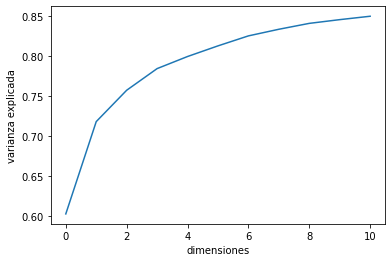

In [36]:
y = labs

print('Use of  MFCCs')

Xf = librosa.feature.mfcc(y=data[0,:],
                        sr=srate,n_mfcc=20).flatten()    
for s in range(1,n):
    Mfcc = librosa.feature.mfcc(y=data[s,:],
                        sr=srate,n_mfcc=20).flatten()    
    Xf = np.vstack([Xf,Mfcc])


pca = sklearn.decomposition.PCA(n_components=.85)    
pca.fit(Xf)
evr = pca.explained_variance_ratio_
#print(evr) 

#plt.plot(np.cumsum(evr))  # vemos que la varianza explicada es practicamente 1

X = pca.transform(Xf)
print('Dimension: %d -> %d'%(Xf.shape[1],X.shape[1]))    
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('dimensiones')
plt.ylabel('varianza explicada')
plt.show()




### Fuzzy clustering

 Hemos visto que en el espacio de características, los sonidos pertenecientes a diferentes etiquetas presentan semejanzas por lo que creemos conveniente asumir que la partición sea difusa. Por lo tanto vamos a utilizar el método fuzzy k means, que asume que los diferentes grupos se asemejan entre sí por lo que la pertenecia a un grupo se reflejará en variables de pertenencia difusas.
 


Vamos a realizar el clustering para diferente número de centros y nos fijaremos en el valor del coeficiente FPC (*fuzzy partition coefficient*). Este coeficiente está definido en un rango entre 0 y 1, donde 1 es el mejor resultado posible. Es una métrica que nos dice como de limpios están nuestros datos descritos por cada modelo.

Por lo tanto, escogeremos la representación que mejor nos de ese coeficiente. Después veremos que el resultado tiene sentido, teniendo en cuenta el patrón que siguen nuestros datos.



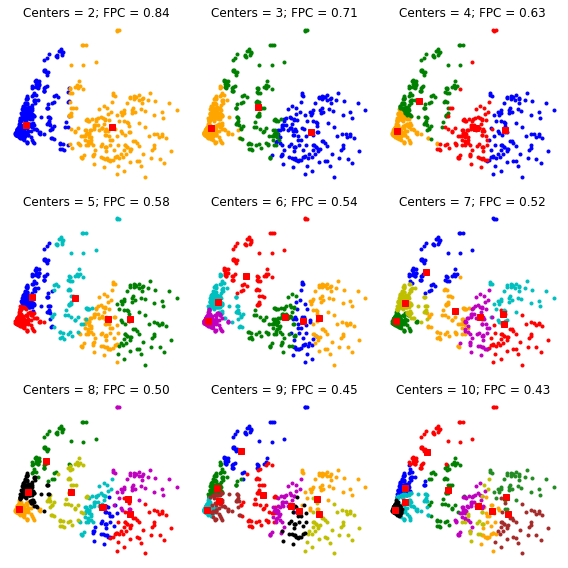

In [37]:
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
fuzzyness = 2
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))

fpcs = []
y_fpreds = []
us = []
fcenters = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X.transpose(), ncenters, fuzzyness, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(X[:,0][cluster_membership == j],
                X[:,1][cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')
    y_fpreds.append(np.argmax(u,axis=0))
    us.append(u)
    fcenters.append(cntr)

fig1.tight_layout()


El FPC es máximo en 2 clusters. Vamos a tomar la premisa de que este resultado es coherente con nuestros datos y posteriormente vamos a mostrar que , en efecto, lo es. 

EL razonamiento posterior lo vamos a poder hacer dado que tenemos las etiquetas de los datos y podemos ver como se distribuye cada una de ellas en el espacio de representación. 


Vamos a graficar como quedarían las etiquetas con solo dos clusters según nuestro modelo, marcando con una X el centro de cada uno de ellos:

Text(0.5, 1.0, 'Dos clusters')

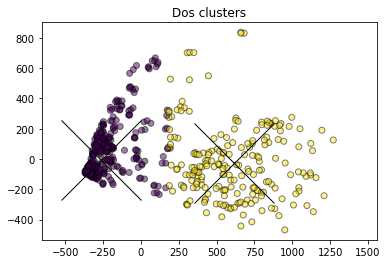

In [38]:

# Etiquetaje para dos clusters , segun la prediccion de el modelo no supervisado:
plt.scatter(X[:, 0], X[:, 1], c=y_fpreds[0],alpha=0.5, edgecolors='k')
plt.plot(fcenters[0][:,0],fcenters[0][:,1],'kx',markersize=80)
plt.axis('equal')
plt.title("Dos clusters")


## Nuestra suposición


Tras escuchar los sonidos y ver como se distribuyen en el espacio de representación, hemos podido observar que las etiquetas 0 y 1 , pertenecientes a los sonidos *Rain* y *Sea waves*, presentan una gran dispersión en el espacio de frecuencias, en cambio las otras 4 etiquetas: *Crackling fire* , *Crickets*, *Chirping birds* y *Water drops*, están todas muy centradas en la misma zona. De hecho, al escuchar estos sonidos, nos percatamos que esta separación tambien toma presencia pues los sonidos de la lluvia y de las olas se parecen, del mismo modo que unos grillos, unos pajaros, unas gotas de agua y el fuego crepitando.

Por tanto, suponemos que nuestro cluster solo ha encontrado dos patrones. Uno que esta formado por los dos sonidos más dispersos: etiquetas 0 y 1, y otro clusters que está formado por los 4 sonidos restantes, que presentan muchas semejanzas entre si. 

Ploteamos como quedaría esta partición para observar visualmente, que efectivamente, se parece mucho a la predicción del algoritmo, las etiquetas diferencian entre estos dos grupos y los centros son los predichos por el modelo de clustering.



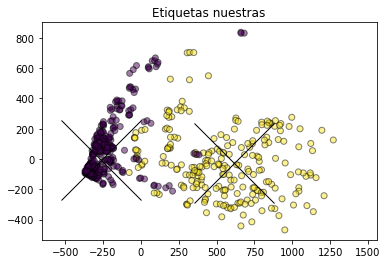

In [39]:
   
# Etiquetaje después de analizar los sonidos y caracteristicas de nuestra base de datos
eti_1 = (np.array(labs==0) + np.array(labs ==1) )


plt.scatter(X[:,0], X[:,1], c = eti_1 ,alpha=0.5, edgecolors='k') # etiquetaje real de los grupos (0,1) y (2,3,4,5)
plt.plot(fcenters[0][:,0],fcenters[0][:,1],'kx',markersize=80)
plt.axis('equal')
plt.title("Etiquetas nuestras")

plt.show()

### Centros para cada una de las dimensiones

Vamos a ver para **alguna** de las otras dimensiones, como se ajustan los centros predichos al agrupamiento que hemos considerado en las etiquetas.

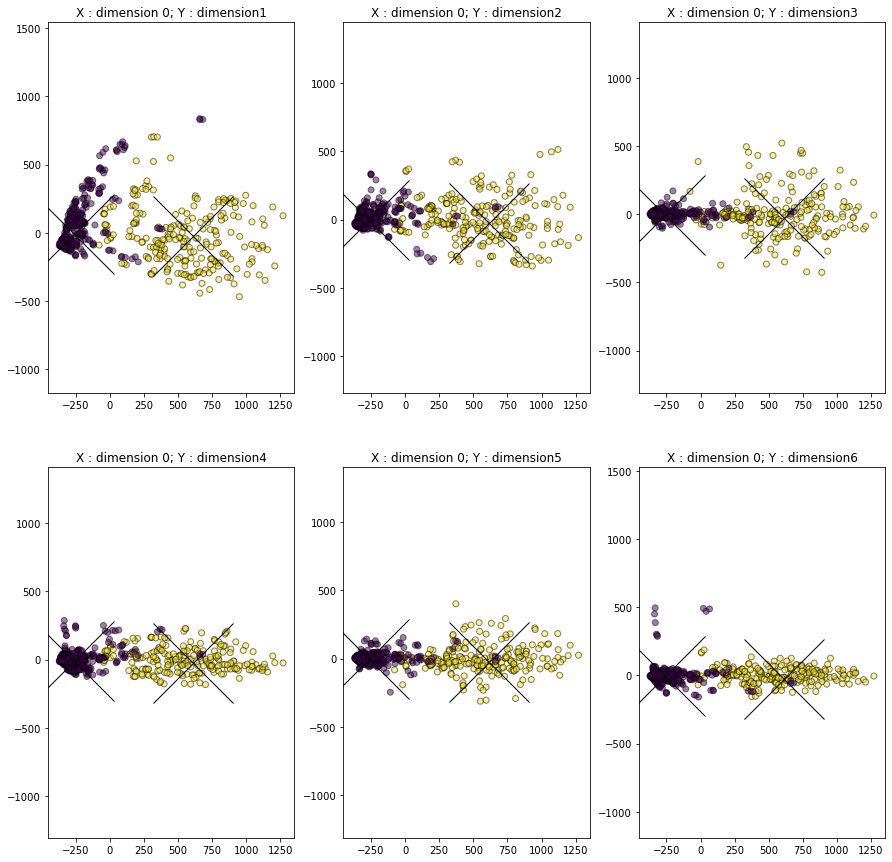

In [40]:
plt.subplots(2,3, figsize=(15, 15))
for i in range(1,7):
    
    plt.subplot(2, 3, i)
    plt.scatter(X[:,0], X[:,i], c = eti_1 ,alpha=0.5, edgecolors='k')
    plt.plot(fcenters[0][:,0],fcenters[0][:,1],'kx',markersize=80)
    plt.axis('equal')
    plt.title('X : dimension 0; Y : dimension{0}'.format(i))
    
plt.show()


### Conclusiones
El clustering no supervisado nos ha dado una visión superficial de la estructura de nuestros datos. Tenemos un grupo de etiquetas muy disperso, compuesto por las etiquetas 0 y 1, y otro grupo con los puntos, aperentemente, muy juntos en la represetanción en el espacio de características. Tras la escucha de estos sonidos hemos concluido que los resultados son coherentes, pues los sonidos de los pajaros, grillos, fuego y gotas de agua, presentan cierta semblanza en el tono y en la forma, en cambio los sonidos de lluvia y olas del mar se escuchan como sonidos muy dispersos que parecen mezclarse con el ruido de fondo.

# Métodos Supervisados

## Creacion de Dataset para el supervisado

Para cada clase, vamos a extraer el 50% de los datos, y la idea es hacero de la forma más representativa posible, para que nuestro entrenamiento se nutra de los datos más representativos de cada cluster y evite outliers.

Vamos a utilizar el algoritmo de clustering k-medoids. Este es un algoritmo particional, es decir, rompe el dataset en grupos. De la misma forma de K-means minimiza el error cuadrático total, este minimiza la suma de disimilaridades entre puntos supuestos como pertenecientes a una etiqueta y el punto designado como clusters.  

Hemos decidido escoger este método, porque toma los puntos del dataset como centros, no como k-means, por lo tanto, no vamos a tener que calcular las distancias de los puntos a los centros, sino que simplemente, tomaremos como centros de cada clase la cantidad de puntos deseada en nuestro dataset reducido. 

Como nostros queremos reducir el tamaño de nuestros datos al 50%, vamos a partir nuestro dataset por etiquetas, y para cada subconjunto (todos de la misma etiqueta), escogeremos como número de centros la mitad de los datos, asumiendo que si son los más centrados, son los que mejor representan la clase. 


In [41]:
N_clas = len(class_names) # no.de clases
n,d = X.shape  # size and (raw) dimension

step = (n//N_clas)  # cada step en el data set vamos a tener un cojunto de etiquetas diferente

n_train = step//2 #nos vamos a quedar con la mitad

x_red =  np.empty((0, len(X[1,:])))
y_red = np.int16(np.kron(np.arange(N_clas),np.ones(n_train)))

for i in range(0,n,step):
    kmedoids = KMedoids(n_clusters=n_train, random_state=0)   # para cada classe, nos quedaremos con la mitad más representativa, es decir con las n_train mas centrados  
    kmedoids.fit(X[i:(i+step)])
    p1=kmedoids.cluster_centers_
    x_red= np.concatenate([x_red, p1])


# ahora tenemos el 50% de la muestra incial

    

Veamos como está distribuido nuestro data set. 
    
Se observa que las últimas 3 etiquetas (especialmente la 3 y 4), son muy parecidas, como ya vimos en el primer apartado, por lo que preveemos que el algoritmo tenga problemas a la hora de diferenciarlas.

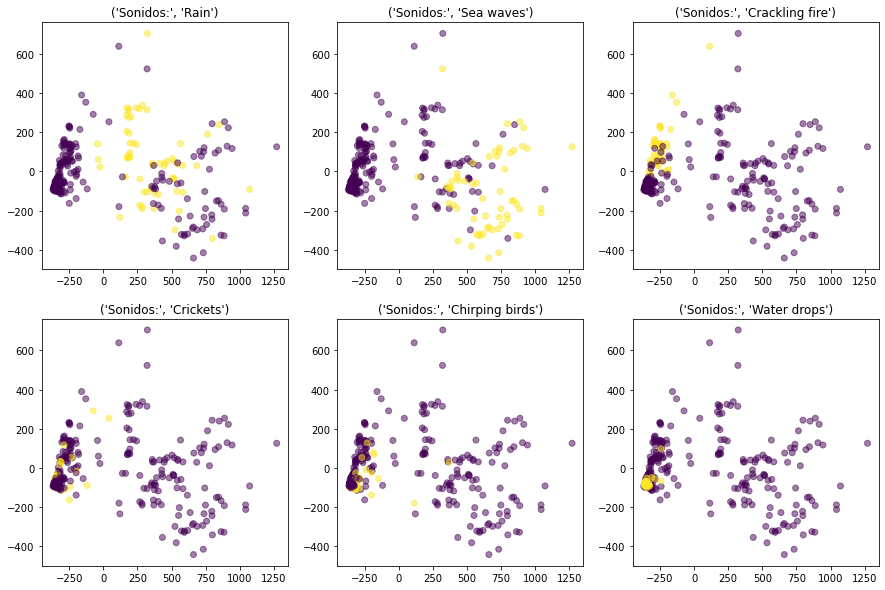

In [42]:
plt.subplots(2,3, figsize=(15, 10))
for i in range (0,6):
    plt.subplot(2, 3, i+1)
    plt.scatter(x_red[:,0], x_red[:,1], c = np.array(y_red== i), alpha = 0.5)
    plt.title(("Sonidos:" , class_names[i]))
plt.show()

El data set reducido que hemos selecionado es el data set con el que vamos a hacer la partición de entrenemiento y test. El otro restante no lo vamos a tener en cuenta, pues aún sabiendo que nos daría una visión mas generalizada de nuestros resultados en el proceso de testing, nuestro modelo estaria siendo sesgado, ya que sabemos que la otra mitad es la menos representativa de nuestros datos y el proceso de entrenamiento no los va a tener en cuenta.  

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x_red, y_red, random_state=14, test_size=0.3)

# ahora estandarizamos las variables. No vamos a utilizar la normalización porque no creemos que los datos sigan una distribución normal

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

## Algoritmos supervisados :

### Metricas que vamos a utilizar

Las métricas que vamos a utilizar todas pretenden medir la precisión de nuestra predicción. 
* El **coeficiente de Kappa** nos muestra el nivel de concordancia entre dos predicciones. Midiendo el efecto del azar en la clasificación.
* La **matriz de confusión** nos muestra de una manera visual las predicciones contra sus etiquetas reales. Visualizando así los aciertos y los fallos de clasificación.
* Y el **Overall Acurracy (OA)** nos muestra el porcentaje de los aciertos sobre el total.



### KNN 


Primeramente vamos a utilizar el método conocido como k-vecinos más próximos. Este método calcula las distancias a los k vecinos más próximos para clasificar cada vector, es razonable que presente fallos en el etiquetaje de muestras pertenecientes a las etiquetas 3 y 4, pues hemos visto que estas están muy cerca o incluso comparten zona, por lo que va ser muy complejo que el modelo pueda diferenciarlas tomando solo como referencia los n vecinos más próximos. 


Hemos elegido *n_neighbors = 3* después de utilizar el método de Gridsearch cross validation. Este método calcula qué parámetros ajustan mejor a los resultados, haciendo cross validation para comparar la predicción con un pequeño conjunto de test en cada partición de bloques. Nosotros vamos a utilizar 5 bloques.

Este método nos da una idea más representativa de cual es la precisión de clasificación 

mejor paramtero para n_neoghbors :  {'n_neighbors': 3}
OA train 0.82
Kappa test 0.70


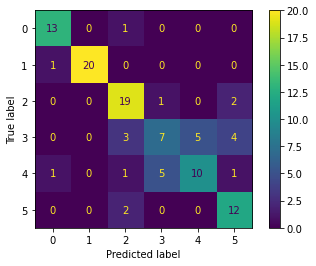

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       1.00      0.95      0.98        21
           2       0.73      0.86      0.79        22
           3       0.54      0.37      0.44        19
           4       0.67      0.56      0.61        18
           5       0.63      0.86      0.73        14

    accuracy                           0.75       108
   macro avg       0.74      0.75      0.74       108
weighted avg       0.74      0.75      0.74       108



In [44]:
   


knn2 = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 12)}# diccionario para todos los posibles valores de n_neighbors

knn_gscv = GridSearchCV(knn2, param_grid, cv=10) # utilizamos gridsearch para testear todos los posibles valores de n_neighbors



knn_gscv.fit(X_train, y_train) #fit modelo 
print("mejor paramtero para n_neoghbors : ",knn_gscv.best_params_)

knn_gscv=knn_gscv.best_estimator_  # nos quedamos con el mejor modelo

knn_pred = knn_gscv.predict(X_test)



# vemos que tenemos problemas con las etiquedstas 3-4. como ya previsiblemente, suponiamos
print('OA train %0.2f' % knn_gscv.score(X_train, y_train))
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,knn_pred))
plot_confusion_matrix(knn_gscv, X_test, y_test) 
plt.show()

print(classification_report(y_test, knn_pred))



Como era de esperar, el algoritmo presenta fallos a la hora de clasificar los elementos pertenecientes a la clase 3 y 4.  En cambio no falla con la predicción de las quintas etiquetas, y es que si vemos los graficos anteriores, podemos ver que estos puntos estan extremadamente juntos, por lo que el algoritmo consigue clasificarlos bien.

## SVM con GridsearchCV

Ahora volvemos a utilizar GridSearch CrossValidation para encontrar los mejores parámetros para el método de Máquinas de Soporte Vectorial (svm) para clasificación. Este método nos permite encontrar cual es la anchura del kernel óptima (gamma) y cual es el valor del parámetro de regularización (C). 

El algoritmo SVM intenta encontrar una frontera óptima para cada clase, pasando a un espacio proyectado (de Hilbert) donde esta frontera es lineal. Como este método no se basa en la proximidad de los vecinos, puede que sea más interesante para nuestro caso, vista la distribución de los puntos en el espacio de características. 




SVC(C=69.51927961775606, gamma=1.8329807108324339)
OA train 0.83
OA test 0.78
Kappa test 0.73


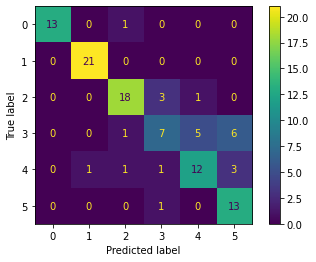

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.95      1.00      0.98        21
           2       0.86      0.82      0.84        22
           3       0.58      0.37      0.45        19
           4       0.67      0.67      0.67        18
           5       0.59      0.93      0.72        14

    accuracy                           0.78       108
   macro avg       0.78      0.79      0.77       108
weighted avg       0.78      0.78      0.77       108



In [45]:
gammas = np.logspace(-5, 5, 20)
Cs = np.logspace(-5, 5, 20)
tuned_parameters = { 'gamma': gammas,'C': Cs}    

#GridSearchCV nos permite hacer cross validation de forma automatica



clf = GridSearchCV(svm.SVC(kernel='rbf'), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf.fit(X_train,y_train)
clf=clf.best_estimator_  # elegimos el mejor estimador de entre toddas las combinaciones de gammas i Cs
print(clf)

print('OA train %0.2f' % clf.score(X_train, y_train)) 
print('OA test %0.2f' % clf.score(X_test, y_test))
preds_test = clf.predict(X_test)
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,preds_test))



# vemos que hay mucha confusion en distinguir la etiqueta 3 (Crickets) con los  4 y 5 , con Chirping birds y con Water Drops

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

print(classification_report(y_test, preds_test))

Aqui vemos que hemos mejorado en la precisión en general y en particular en las muestras pertencientas a la etiqueta 4.
Seguimos fallando en la etiqueta 3. 

## Exctraccion de características con Random Forest

Los modelos Random forest nos permiten la opción de extraer las características y darnos un valor según su importancia. Vamos a utillizar este modelo para clasificar también nuestro dataset y después comprobaremos que nuestro modelo mejora al reducir las características y nos quedaremos con las 9 más importantes.

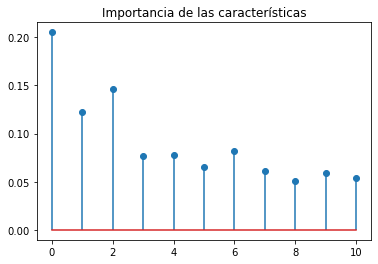

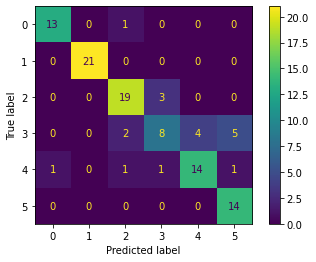

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       1.00      1.00      1.00        21
           2       0.83      0.86      0.84        22
           3       0.67      0.42      0.52        19
           4       0.78      0.78      0.78        18
           5       0.70      1.00      0.82        14

    accuracy                           0.82       108
   macro avg       0.82      0.83      0.82       108
weighted avg       0.82      0.82      0.81       108

Kappa test 0.79


In [46]:
# Creación del modelo
# ==============================================================================
modelo = RandomForestClassifier(
            n_estimators = 150,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = True,
            n_jobs       = -1,
            random_state = 0
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

# Error de test del modelo inicial
# ==============================================================================
pred = modelo.predict(X = X_test)

plt.stem(modelo.feature_importances_)
plt.title("Importancia de las características")
plt.show()

plot_confusion_matrix(modelo, X_test, y_test)  
plt.show()
print(classification_report(y_test,pred))
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,pred))



Podemos observar como de importantes son cada una de las dimensiones de nuestros datos, y por otra parte, vemos que este modelo de clasificación mejora un poco los resultados. Sin embargo, seguimos teniendo fallos en la etiqueta 3. 


## Quitamos dimensiones

Vamos a quedarnos con las 9 más importantes y re-evaluaremos nuestro modelo, para ver si mejoramos o no.

Res RF 9:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.95      1.00      0.98        21
           2       0.86      0.86      0.86        22
           3       0.67      0.53      0.59        19
           4       0.81      0.72      0.76        18
           5       0.74      1.00      0.85        14

    accuracy                           0.84       108
   macro avg       0.84      0.85      0.84       108
weighted avg       0.84      0.84      0.84       108



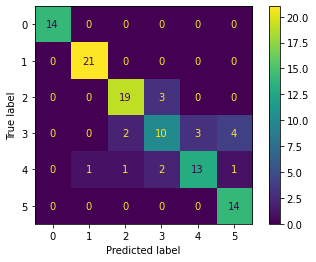

Kappa test 0.81


In [47]:
idx = np.argsort(modelo.feature_importances_)

nbest = 9 # nos quedamos con 9
idx = np.flip(idx)  # revert to put best feat. first
rf2 = modelo = RandomForestClassifier(
            n_estimators = 200,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = True,
            n_jobs       = -1,
            random_state = 0
         )

rf2.fit(X_train[:,idx[:nbest]], y_train)
y2 = rf2.predict(X_test[:,idx[:nbest]])
print('Res RF %d:' % nbest, classification_report(y_test,y2))
plot_confusion_matrix(rf2, X_test[:,idx[:nbest]], y_test)  
plt.show()
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,y2))


## vemos que el modelo no empeora. por lo que vamos a quitarle las columnas


Vemos que hemos mejorado las predicciones en practicamente todas las etiquetas , aunque seguimos fallando en la etiqueta 3. Los resultados son considerablemente mejores, además, hemos reducido la dimensionalidad. Por tanto, tomaremos la decisión de utilizar este dataset en el apartado posterior.

# Ensembles
Por último, empleando solo el conjunto reducido de muestras etiquetadas hemos utilizado estrategias de combinación de clasificadores (métodos 'ensemble') para intentar mejorar los resultados de la clasificación.

### Bagging

Con este método estamos realizando 1000 iteraciones del conjunto de entrenamiento y luego almacenando la moda de las predicciones obtenidas del conjunto de test en el vector 'yb'.

In [48]:


# Ahora nos quedamos con las dimensiones utilies
X_test = X_test[:,idx[:nbest]]
X_train = X_train[:,idx[:nbest]]

# Definimos el predictor y algunos parámetros
predictor = DecisionTreeClassifier
criterion = 'entropy'
max_depth = None
report = metrics.classification_report

# Train bagging ensemble
T = 1000
bag = [] 
for t in range(T):
    Xb, yb = resample(X_train, y_train, replace=True)
    model = predictor(criterion=criterion,
                      max_depth=max_depth)
    model.fit(Xb,yb)
    bag.append(model)

# Test
preds = np.zeros((len(y_test), T)) 
for t in range(T):
    preds[:,t] = bag[t].predict(X_test)

# Para la clasificación usamos majority vote, para ello usaremos la moda
yb, votes = mode(preds, axis=1) 

print('Res bag: ', report(y_test, yb))

confusion_matrix(y_test,yb)
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,yb))


Res bag:                precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.91      0.95      0.93        21
           2       0.86      0.82      0.84        22
           3       0.50      0.47      0.49        19
           4       0.75      0.50      0.60        18
           5       0.67      1.00      0.80        14

    accuracy                           0.76       108
   macro avg       0.76      0.77      0.75       108
weighted avg       0.76      0.76      0.75       108

Kappa test 0.71


Vemos como el nivel de Accuracy está sobre 0.75, con lo cual no mejora con respecto a los métodos anteriores. También vemos en la matriz de confusión que seguimos teniendo problemas a la hora de clasificar correctamente los puntos pertenecientes a las clases 3 y 4.

El posible motivo por el cual no vemos una mejora en el modelo es por el hecho de que en el Bagging estamos usando Árboles de Clasificación, cuando otros métodos como SVM o Random Forest nos han mostrado un mejor rendimiento anteriormente.

 A continuación vamos a probar con otro método ensemble

## AdaBoost


Vamos a probar con el algoritmo de Boosting, en concreto el Adaboost. Estos algoritmos pretenden entrenar los conocidos como weak learners para transformarlos en strong learners, así conseguir extraer más información.


In [49]:

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=450,
                         learning_rate=2.8)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)


print("res ADA : ", report(y_test,y_pred))

print(confusion_matrix(y_test,y_pred))
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,y_pred))

res ADA :                precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.95      0.86      0.90        21
           2       0.86      0.82      0.84        22
           3       0.38      0.42      0.40        19
           4       0.67      0.44      0.53        18
           5       0.58      0.79      0.67        14

    accuracy                           0.69       108
   macro avg       0.70      0.70      0.69       108
weighted avg       0.71      0.69      0.69       108

[[12  1  1  0  0  0]
 [ 3 18  0  0  0  0]
 [ 0  0 18  2  1  1]
 [ 0  0  2  8  2  7]
 [ 1  0  0  9  8  0]
 [ 0  0  0  2  1 11]]
Kappa test 0.63


Tampoco estamos viendo mejoras en términos de Accuracy y además, viendo la matriz de confusión vemos que el problema reside en la clasificación de las etiquetas 3 y 4, en cambio, este método también parece confundir en gran parte la etiqueta 5. En ningun momento hemos conseguido mejorar o igualar los resultados obtenidos por el Random Forest 


*No hemos encontrado ningun  otro método ensemble que mejore los resultados expuestos, por lo que hemos obviado el mostrarlos*

## Conclusiones

Primeramente hemos utilizado métodos de clustering no supervisados para tener una idea general sobre el conjunto de datos del que partiamos y conseguir entender, de manera superficial, como se distribuyen las diferentes etiquetas en el espacio de características.

Después hemos reducido nuestro data set, tomando como puntos aquellos que más centrados estaban en el espacio de representación, considerando estos como los más representativos de cada clase. Con este nuevo data set, hemos probado diferentes modelos de clasificación obtieniendo resultados bastante buenos excepto en las etiquetas 3 y 4, lo cual, como hemos adelantado, nos ha parecido coherente.

Nuestro mejor modelo, a pesar de haber probado con otros métodos ensemble, ha sido el Random Forest, habiendo reducido las dimensiones del conjunto previamente (de 11 a 9). Entendemos que hemos encontrado los parámetros adecuados para random forest, de forma que los arboles de clasificación no estan correlacionados entre sí,y consecuentemente los errores que cometa  cada uno de ellos no seran repetidos por los otros. Esto posiblemente no lo hayamos podido conseguir con los otros métodos ensembles.



## Apéndice : Division de tareas
Vamos a intentar dividir el problema en dos partes para conseguir mejorar nuestro modelo. Las dos divisiones que haremos : Primeramente vamos a construir un modelo  que solo distinguirá o las etiquetas 0,1,2,3 y 5, siendo esta etiqueta 3 el conjunto de las etiquetas 3 y 4 de nuestro data set originial. Después, especializaremos otro modelo, que se encargará de diferneciar solo estas dos etiquetas, clasificadas como 3 por el primer modelo nombrado.


Redefinimos las etiquetas  para entrenar y comparar las soluciones . Agrupamos las etiquetas 3 y 4 de nuestro data set original con la etiqeta 3

In [50]:
y_test2 = y_test.copy()  # hacemos copias para poder editarlas

y_train2 = y_train.copy()

y_train2[y_train2 ==4] = 3  # redefinimos las etiquetas 
y_test2[y_test2 ==4] = 3



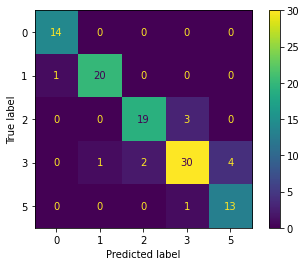

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.95      0.95      0.95        21
           2       0.90      0.86      0.88        22
           3       0.88      0.81      0.85        37
           5       0.76      0.93      0.84        14

    accuracy                           0.89       108
   macro avg       0.89      0.91      0.90       108
weighted avg       0.89      0.89      0.89       108

Kappa test 0.86


In [51]:
# contruimos el nuevo modelo
modelo2_1 = RandomForestClassifier(
            n_estimators = 189,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = True,
            n_jobs       = -1,
            random_state = 0
         )

# Entrenamiento del modelo
# ==============================================================================
modelo2_1.fit(X_train, y_train2)

# Error de test del modelo inicial
# ==============================================================================
pred2 = modelo2_1.predict(X = X_test)

plot_confusion_matrix(modelo2_1, X_test, y_test2)  
plt.show()
print(classification_report(y_test2,pred2))
print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test2,pred2))


### Clasificamos entre las 3 y 4

Ahora vamos a intentar classificar todas las etiquetas que nuestro modelo ha clasificado como 3 een sus dos etiquetas reales : 3 y 4. 
Para ello importamos todas las etiquetas que nuestro modelo ha predecido como tal

In [52]:
X2_train = X_train[y_train2 == 3]
X2_test = X_test[pred2 == 3]  # las predecidas

y2_train = y_train[y_train2 == 3]
y2_test = y_test[pred2 == 3]    # las predecidas

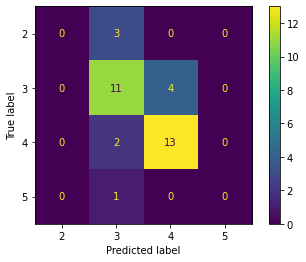

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.65      0.73      0.69        15
           4       0.76      0.87      0.81        15
           5       0.00      0.00      0.00         1

    accuracy                           0.71        34
   macro avg       0.35      0.40      0.38        34
weighted avg       0.62      0.71      0.66        34



C:\Users\34695\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\34695\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\34695\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
modelo2_2 = RandomForestClassifier(
            n_estimators = 50,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = True,
            n_jobs       = -1,
            random_state = 0
         )

# Entrenamiento del modelo
# ==============================================================================
modelo2_2.fit(X2_train, y2_train)

# Error de test del modelo inicial
# ==============================================================================
pred3 = modelo2_2.predict(X = X2_test)

plot_confusion_matrix(modelo2_2, X2_test, y2_test)  
plt.show()
print(classification_report(y2_test,pred3))

Estamos acertando de esta forma  12 de 18 en  cada una  de ellas. El resultado es prácticamente el mismo que en nuestro modelo más refinado, que clasificaba 10 de 18 en la etiqueta 3  y 12 de 18 en la etiqueta 4 . 
En cambio, vemos que en las etiquetas 2 y 5, hemos predecido con un poco menos de acierto. Por lo que consideramos que no es un modelo acertado

Creemos que con una cantidad superior de datos para entrenar se conseguiría mejorar la clasificación. Pues solo hemos tenido 83 datos para entrenar a nuestro modelo diferenciador ente 3 y 4.

In [54]:
len(y2_train)

83

Veamos como se representan nuestros puntos en el espacio de caracterísitcas y vemos que, efectivamente, es una tarea compleja:

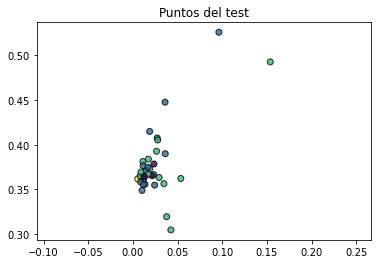

In [55]:
plt.scatter(X2_test[:,0], X2_test[:,1], c = y2_test ,alpha=0.8, edgecolors='k')
#plt.plot(fcenters[0][:,0],fcenters[0][:,1],'kx',markersize=80)
plt.axis('equal')
plt.title("Puntos del test")

plt.show()